In [1]:
import pandas as pd
import numpy as np
import torch
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### Import and explore dataset

In [2]:
NYCdf = pd.read_csv('../scripts/data/NYCschools/final_data_interventions_max_frac.csv')
NYCdf

,AP/IB,Calculus,Counselors,FracSAT/ACT,black,Hispanic,white,lat,long,gis_x,gis_y,neigh1,neigh2,neigh3,neigh4,neigh5
0,1.0,1.0,1.0,0.163317,1,0,0,40.649662,-73.958204,9.958480e+05,175968.536711,132,105,225,144,41
1,1.0,1.0,2.0,0.220657,0,1,0,40.859515,-73.887958,1.015243e+06,252441.989916,283,99,2,270,64
2,1.0,0.0,1.0,0.296588,0,1,0,40.859576,-73.889183,1.014904e+06,252463.809247,99,283,1,270,64
3,1.0,0.0,1.0,0.107330,0,1,0,40.818359,-73.911368,1.008782e+06,237439.880982,191,65,156,307,290
4,1.0,1.0,1.0,0.228381,0,1,0,40.878025,-73.913255,1.008238e+06,259178.021389,271,100,305,8,230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1.0,1.0,4.0,0.198575,1,0,0,40.744448,-73.728974,1.059350e+06,210615.167144,213,248,275,316,212
341,1.0,0.0,2.0,0.067594,0,1,0,40.774969,-73.986084,9.881044e+05,221619.088133,49,13,343,159,82
342,0.0,0.0,1.0,0.222222,1,0,0,40.698381,-73.745498,1.054820e+06,193818.062362,316,236,243,338,62
343,1.0,0.0,2.6,0.102564,0,1,0,40.774700,-73.985454,9.882789e+05,221521.223661,13,49,341,159,82


In [3]:
NYCdf['Race'] = NYCdf.apply(lambda x: 1 if x['white']==1 else 0, axis=1)

In [4]:
NYCdf = NYCdf[['Race', 'AP/IB', 'Calculus', 'Counselors', 'FracSAT/ACT', 'lat', 'long']]
NYCdf.rename(columns={'Race': 'S', 'AP/IB': 'T', 'Calculus': 'Cl', 'Counselors': 'Cs', 'FracSAT/ACT': 'Y'}, inplace=True)
# 'lat': 'La', 'long': 'Lo'
NYCdf

,S,T,Cl,Cs,Y,lat,long
0,0,1.0,1.0,1.0,0.163317,40.649662,-73.958204
1,0,1.0,1.0,2.0,0.220657,40.859515,-73.887958
2,0,1.0,0.0,1.0,0.296588,40.859576,-73.889183
3,0,1.0,0.0,1.0,0.107330,40.818359,-73.911368
4,0,1.0,1.0,1.0,0.228381,40.878025,-73.913255
...,...,...,...,...,...,...,...
340,0,1.0,1.0,4.0,0.198575,40.744448,-73.728974
341,0,1.0,0.0,2.0,0.067594,40.774969,-73.986084
342,0,0.0,0.0,1.0,0.222222,40.698381,-73.745498
343,0,1.0,0.0,2.6,0.102564,40.774700,-73.985454


In [5]:
# Cs is descrte, how many categories?
len(sorted(NYCdf['Cs'].unique()))

31

<AxesSubplot:xlabel='T', ylabel='Count'>

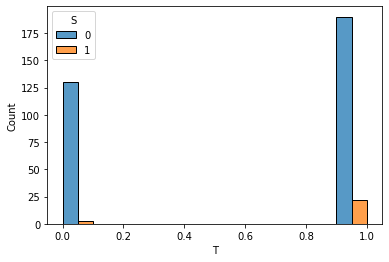

In [6]:
sns.histplot(NYCdf, x = 'T', hue = 'S', multiple = 'dodge')

<AxesSubplot:xlabel='Y', ylabel='Count'>

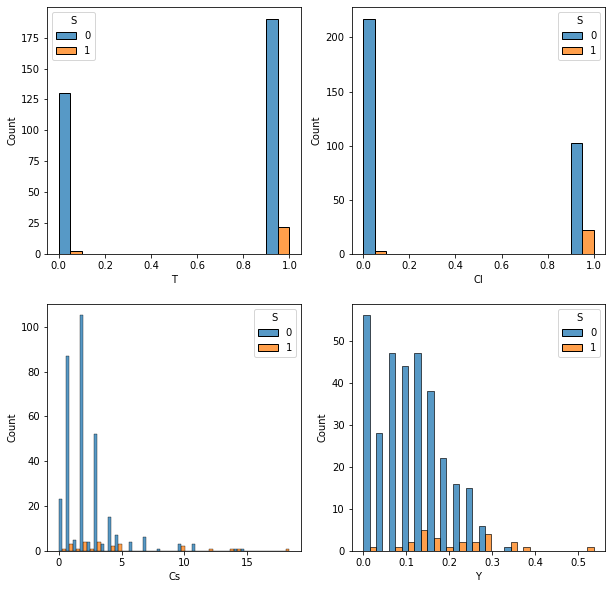

In [7]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
sns.histplot(NYCdf, x = 'T', hue = 'S', multiple = 'dodge', ax = axs[0,0])
sns.histplot(NYCdf, x = 'Cl', hue = 'S', multiple = 'dodge', ax = axs[0,1])
sns.histplot(NYCdf, x = 'Cs', hue = 'S', multiple = 'dodge', ax = axs[1,0])
sns.histplot(NYCdf, x = 'Y', hue = 'S', multiple = 'dodge', ax = axs[1,1])

## Bootstrapped dataset, composedY

In [811]:
from sklearn.utils import resample
n = 20000

X_cols = ['T', 'Cl', 'Cs']
X = NYCdf[X_cols].to_numpy()
y = NYCdf['Y'].to_numpy()
S = NYCdf['S'].to_numpy().reshape(len(y), -1)
boot_S = resample(S, replace=True, n_samples=n, random_state=42)

boot_X = resample(X, replace=True, n_samples=n, random_state=42)

boot_y = resample(y, replace=True, n_samples=n, random_state=42)


def ReLU(x):
    return x * (x > 0)

In [814]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
noise_mean = 0.5
std = 0.4
wx_linear = np.random.rand(3)
ws_linear = np.random.rand(1)
wsx_linear = np.random.rand(3)
beta_non_A = np.random.normal(loc=0.8, scale=std, size=(7, 1))
beta_A = np.random.normal(loc=1.2, scale=std, size=(8, 1))
gamma_non_A = np.random.normal(loc=0.8, scale=std, size=(3, 1))
gamma_A = np.random.normal(loc=1.6, scale=std, size=(4, 1))
# print(beta_non_A, gamma_non_A)
beta = np.concatenate((beta_non_A, beta_A), axis=0).squeeze()
gamma = np.concatenate((gamma_non_A, gamma_A), axis=0).squeeze()
print("beta: ", beta)
print("gamma: ", gamma)
X_cols = ['T', 'Cl', 'Cs']
X = NYCdf[X_cols].to_numpy()
y = NYCdf['Y'].to_numpy()
S = NYCdf['S'].to_numpy().reshape(len(y), -1)
n = 20000

# noise create
boot_noise_nonlin = np.random.normal(0.5, std, n)
# A structural equation
boot_A = (((wsx_linear.dot(boot_X.T) * boot_S.squeeze())**2) + ReLU(wx_linear.dot(boot_X.T))).reshape(-1, 1)
# A + noise
boot_A_noise = boot_A + boot_noise_nonlin.reshape(-1, 1)
# scale to [0,1]
boot_normalimze_nonlin = MinMaxScaler(feature_range=(0, 1)).fit(boot_A_noise)
boot_A_nonlinear_bounded01 = boot_normalimze_nonlin.transform(boot_A_noise)

boot_noise_composed_Y = np.random.normal(1, std, n)

def generate_g(beta, S, X, A, rescale=3):
    return beta.dot(np.concatenate([S, X, S*X, A, X*A, S*A, S*A*X], axis=1).T)/rescale

def generate_h(gamma, A, X):
    return gamma.dot(np.concatenate([X, A, A*X], axis=1).T)
boot_g = generate_g(beta, boot_S, boot_X, boot_A_nonlinear_bounded01)
boot_h = generate_h(gamma, boot_A_nonlinear_bounded01, boot_X)
## Create Y_pi
y0_scale=20
def composed_Y_no_divide(y, g, h, noise, y0_scale=y0_scale):
    return (y0_scale*y + g + h + noise)
boot_Y_no_div_strong_A_coeffs = composed_Y_no_divide(boot_y, boot_g, boot_h, boot_noise_composed_Y)
## Compose the dataframe
# NYC_pi_nonlinear_bounded_01_composed_Y = NYCdf[X_cols + ['S', 'pi_nonlinear_bounded01', 'pi_nonlinear_mu_bounded01', 'Y_composed']]
NYC_pi_nonlinear_bounded_01_boot_20k_composed_Y_no_div_strong_A_coeffs_relu = \
    np.concatenate((boot_X, boot_S, boot_A_nonlinear_bounded01, boot_A, boot_Y_no_div_strong_A_coeffs.reshape(-1, 1)), axis=1)
NYC_pi_nonlinear_bounded01_boot_20k_composed_Y_df_no_div_strong_A_coeffs_relu = \
    pd.DataFrame(NYC_pi_nonlinear_bounded_01_boot_20k_composed_Y_no_div_strong_A_coeffs_relu\
        , columns=['T', 'Cl', 'Cs', 'S', 'A', 'A_mu', 'Y'])

beta:  [ 0.91161652  1.20420611  0.56764875  0.58993208  0.57144793  0.43036686
 -0.24501961  1.58014787  1.52657803  0.5904496   1.02878157  0.90303727
  0.91866248  0.34415174  0.94821002]
gamma:  [1.03908819 1.82379521 0.95769321 1.64888767 1.39382574 1.35989846
 1.97897593]


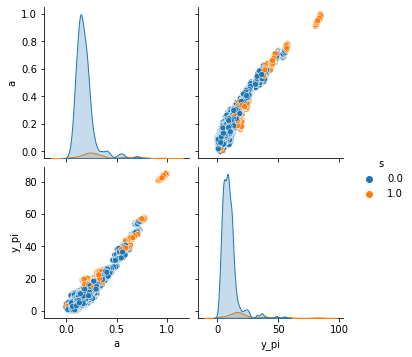

In [815]:
dbug_boot_df_actions = pd.DataFrame(np.concatenate((boot_A_nonlinear_bounded01, boot_S, boot_Y_no_div_strong_A_coeffs.reshape(-1, 1)), axis=1), columns=['a', 's', 'y_pi'])
sns.pairplot(dbug_boot_df_actions, hue='s')

In [816]:
print(np.mean(boot_h), np.mean(boot_h[boot_S.squeeze()==0]), np.mean(boot_h[boot_S.squeeze()==1]))
print(np.mean(boot_g), np.mean(boot_g[boot_S.squeeze()==0]), np.mean(boot_g[boot_S.squeeze()==1]))
print(np.mean(boot_y*y0_scale), np.mean((boot_y*y0_scale)[boot_S.squeeze()==0]), np.mean((boot_y*y0_scale)[boot_S.squeeze()==1]))
print(np.mean(boot_Y_no_div_strong_A_coeffs), np.mean(boot_Y_no_div_strong_A_coeffs[boot_S.squeeze()==0]), np.mean(boot_Y_no_div_strong_A_coeffs[boot_S.squeeze()==1]))

5.901471338454853 5.186204686779018 14.970974203548325
1.3700740770586655 1.1343313884813366 4.359265568745754
2.4097230930548785 2.26303223291226 4.269747145943976
10.682134122425722 9.585935558352347 24.581811947865013


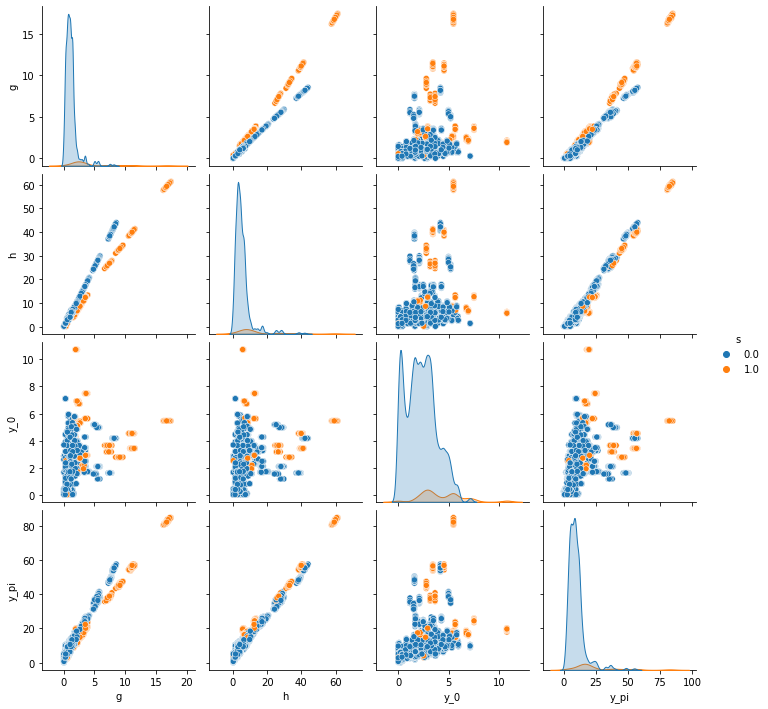

In [817]:
dbug_boot_df = pd.DataFrame(np.concatenate((boot_g.reshape(-1, 1), boot_h.reshape(-1, 1), boot_S, (boot_y*y0_scale).reshape(-1, 1), \
                    boot_Y_no_div_strong_A_coeffs.reshape(-1, 1)), axis=1), columns=['g', 'h', 's', 'y_0', 'y_pi'])
sns.pairplot(dbug_boot_df, hue='s')

In [818]:
A_1s = np.ones(boot_A_nonlinear_bounded01.shape)
A_0s = np.zeros(boot_A_nonlinear_bounded01.shape)
A_03s = np.full(boot_A_nonlinear_bounded01.shape, 0.3)
A_05s = np.full(boot_A_nonlinear_bounded01.shape, 0.5)
A_07s = np.full(boot_A_nonlinear_bounded01.shape, 0.7)

mean y_0 A0 response:  0.12048615465274393
mean y_0 s0: 0.113151611645613, s1: 0.21348735729719875
mean Y A0 response:  7.948583117399583
mean Y s0: 7.426400332212982, s1: 14.569803686338851
mean g A0 response:  0.8232533551143412
mean g s0: 0.7517578551675957, s1: 1.729808470034154
mean h A0 response:  3.714741055373039
mean h s0: 3.4092429939533937, s1: 7.588423040733769


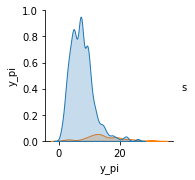

In [819]:
boot_g_A0s = generate_g(beta, boot_S, boot_X, A_0s)
boot_h_A0s = generate_h(gamma, A_0s, boot_X)
## Create Y_pi
boot_Y_A0s = composed_Y_no_divide(boot_y, boot_g_A0s, boot_h_A0s, boot_noise_composed_Y)
print("mean y_0 A0 response: ", np.mean(boot_y))
print("mean y_0 s0: {}, s1: {}".format(boot_y[boot_S.squeeze()==0].mean(), boot_y[boot_S.squeeze()==1].mean()))
print("mean Y A0 response: ", np.mean(boot_Y_A0s))
print("mean Y s0: {}, s1: {}".format(boot_Y_A0s[boot_S.squeeze()==0].mean(), boot_Y_A0s[boot_S.squeeze()==1].mean()))
print("mean g A0 response: ", np.mean(boot_g_A0s))
print("mean g s0: {}, s1: {}".format(boot_g_A0s[boot_S.squeeze()==0].mean(), boot_g_A0s[boot_S.squeeze()==1].mean()))
print("mean h A0 response: ", np.mean(boot_h_A0s))
print("mean h s0: {}, s1: {}".format(boot_h_A0s[boot_S.squeeze()==0].mean(), boot_h_A0s[boot_S.squeeze()==1].mean()))
dbug_boot_df = pd.DataFrame(np.concatenate((boot_Y_A0s.reshape(-1,1), boot_S.reshape(-1, 1)), axis=1), columns=['y_pi', 's'])
sns.pairplot(dbug_boot_df, hue='s')

mean Y A03 response:  10.929759128673076
mean Y s0: 10.172733685244282, s1: 20.528758903148457
mean g A03 response:  1.407382274139587
mean g s0: 1.2562657023852473, s1: 3.323523865919308
mean h A03 response:  3.714741055373039
mean h s0: 5.6510684997670415, s1: 11.953662861658222


(array([2543., 7614., 6342., 1903.,  762.,  271.,  294.,  204.,   10.,
          57.]),
 array([ 0.47651586,  5.21546579,  9.95441573, 14.69336567, 19.43231561,
        24.17126555, 28.91021548, 33.64916542, 38.38811536, 43.1270653 ,
        47.86601523]),
 <BarContainer object of 10 artists>)

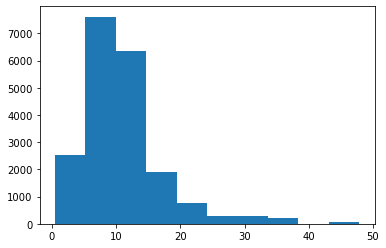

In [820]:
boot_g_A03s = generate_g(beta, boot_S, boot_X, A_03s)
boot_h_A03s = generate_h(gamma, A_03s, boot_X)
## Create Y_pi
boot_Y_A03s = composed_Y_no_divide(boot_y, boot_g_A03s, boot_h_A03s, boot_noise_composed_Y)
print("mean Y A03 response: ", np.mean(boot_Y_A03s))
print("mean Y s0: {}, s1: {}".format(boot_Y_A03s[boot_S.squeeze()==0].mean(), boot_Y_A03s[boot_S.squeeze()==1].mean()))
print("mean g A03 response: ", np.mean(boot_g_A03s))
print("mean g s0: {}, s1: {}".format(boot_g_A03s[boot_S.squeeze()==0].mean(), boot_g_A03s[boot_S.squeeze()==1].mean()))
print("mean h A03 response: ", np.mean(boot_h_A0s))
print("mean h s0: {}, s1: {}".format(boot_h_A03s[boot_S.squeeze()==0].mean(), boot_h_A03s[boot_S.squeeze()==1].mean()))
plt.hist(boot_Y_A03s)

mean Y A 0.5 response:  12.917209802855405
mean Y s0: 12.003622587265147, s1: 24.50139571435486
mean g A05 response:  1.7968015534897512
mean g s0: 1.5926042671970153, s1: 4.3860007965094105
mean h A05 response:  7.7098195424534515
mean h s0: 7.145618836976141, s1: 14.863822742274525


(array([3105., 8370., 5675., 1394.,  630.,  325.,  246.,  198.,    0.,
          57.]),
 array([ 0.91163658,  6.70498764, 12.4983387 , 18.29168976, 24.08504082,
        29.87839188, 35.67174294, 41.46509399, 47.25844505, 53.05179611,
        58.84514717]),
 <BarContainer object of 10 artists>)

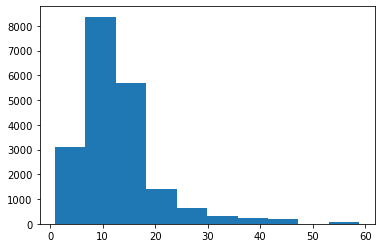

In [821]:
boot_g_A05s = generate_g(beta, boot_S, boot_X, A_05s)
boot_h_A05s = generate_h(gamma, A_05s, boot_X)
## Create Y_pi
boot_Y_A05s = composed_Y_no_divide(boot_y, boot_g_A05s, boot_h_A05s, boot_noise_composed_Y)

print("mean Y A 0.5 response: ", np.mean(boot_Y_A05s))
print("mean Y s0: {}, s1: {}".format(boot_Y_A05s[boot_S.squeeze()==0].mean(), boot_Y_A05s[boot_S.squeeze()==1].mean()))
print("mean g A05 response: ", np.mean(boot_g_A05s))
print("mean g s0: {}, s1: {}".format(boot_g_A05s[boot_S.squeeze()==0].mean(), boot_g_A05s[boot_S.squeeze()==1].mean()))
print("mean h A05 response: ", np.mean(boot_h_A05s))
print("mean h s0: {}, s1: {}".format(boot_h_A05s[boot_S.squeeze()==0].mean(), boot_h_A05s[boot_S.squeeze()==1].mean()))
plt.hist(boot_Y_A05s)

mean Y A 0.7 response:  14.904660477037734
mean Y s0: 13.834511489286015, s1: 28.474032525561263
mean g A07 response:  2.1862208328399153
mean g s0: 1.928942832008783, s1: 5.448477727099512
mean h A07 response:  9.307850937285615
mean h s0: 8.640169174185237, s1: 17.773982622890824


(array([3648., 8551., 5225., 1221.,  529.,  370.,  213.,  186.,    0.,
          57.]),
 array([ 1.34675731,  8.19450949, 15.04226167, 21.89001385, 28.73776603,
        35.58551821, 42.43327039, 49.28102257, 56.12877475, 62.97652693,
        69.82427911]),
 <BarContainer object of 10 artists>)

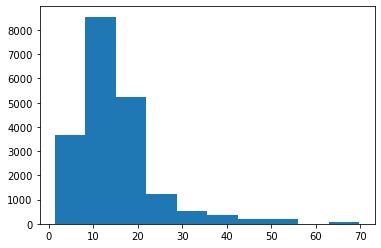

In [822]:
boot_g_A07s = generate_g(beta, boot_S, boot_X, A_07s)
boot_h_A07s = generate_h(gamma, A_07s, boot_X)
## Create Y_pi
boot_Y_A07s = composed_Y_no_divide(boot_y, boot_g_A07s, boot_h_A07s, boot_noise_composed_Y)
print("mean Y A 0.7 response: ", np.mean(boot_Y_A07s))
print("mean Y s0: {}, s1: {}".format(boot_Y_A07s[boot_S.squeeze()==0].mean(), boot_Y_A07s[boot_S.squeeze()==1].mean()))
print("mean g A07 response: ", np.mean(boot_g_A07s))
print("mean g s0: {}, s1: {}".format(boot_g_A07s[boot_S.squeeze()==0].mean(), boot_g_A07s[boot_S.squeeze()==1].mean()))
print("mean h A07 response: ", np.mean(boot_h_A07s))
print("mean h s0: {}, s1: {}".format(boot_h_A07s[boot_S.squeeze()==0].mean(), boot_h_A07s[boot_S.squeeze()==1].mean()))
plt.hist(boot_Y_A07s)

mean Y A1 response:  17.885836488311227
mean Y s0: 16.580844842317312, s1: 34.43298774237088
mean g A1 response:  2.7703497518651616
mean g s0: 2.4334506792264357, s1: 7.042193122984665
mean h A1 response:  11.704898029533863
mean h s0: 10.881994679998884, s1: 22.13922244381528


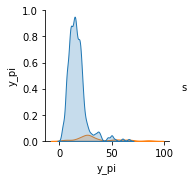

In [823]:
boot_g_A1s = generate_g(beta, boot_S, boot_X, A_1s)
boot_h_A1s = generate_h(gamma, A_1s, boot_X)
## Create Y_pi
boot_Y_A1s = composed_Y_no_divide(boot_y, boot_g_A1s, boot_h_A1s, boot_noise_composed_Y)
print("mean Y A1 response: ", np.mean(boot_Y_A1s))
print("mean Y s0: {}, s1: {}".format(boot_Y_A1s[boot_S.squeeze()==0].mean(), boot_Y_A1s[boot_S.squeeze()==1].mean()))
print("mean g A1 response: ", np.mean(boot_g_A1s))
print("mean g s0: {}, s1: {}".format(boot_g_A1s[boot_S.squeeze()==0].mean(), boot_g_A1s[boot_S.squeeze()==1].mean()))
print("mean h A1 response: ", np.mean(boot_h_A1s))
print("mean h s0: {}, s1: {}".format(boot_h_A1s[boot_S.squeeze()==0].mean(), boot_h_A1s[boot_S.squeeze()==1].mean()))
dbug_boot_df = pd.DataFrame(np.concatenate((boot_Y_A1s.reshape(-1,1), boot_S.reshape(-1, 1)), axis=1), columns=['y_pi', 's'])
sns.pairplot(dbug_boot_df, hue='s')

In [827]:
Path('../scripts/data/NYCschools/').mkdir(parents=True, exist_ok=True)

np.savez_compressed('../scripts/data/NYCschools/boot_20k_composedY_non_div_relu_samplingfix_nonlin_scaled_pi_b01_all.npz', \
    NYC_pi_nonlinear_bounded_01_boot_20k_composed_Y_no_div_strong_A_coeffs_relu)